In [ ]:
import numpy as np

## 1 关于sigma t？

In [ ]:
def get_sigma_schedule(*, beta_start, beta_end, num_diffusion_timesteps):
    """
    Get the noise level schedule
    :param beta_start: begin noise level
    :param beta_end: end noise level
    :param num_diffusion_timesteps: number of timesteps
    :return:
    -- sigmas: sigma_{t+1}, scaling parameter of epsilon_{t+1}
    -- a_s: sqrt(1 - sigma_{t+1}^2), scaling parameter of x_t
    """
    betas = np.linspace(beta_start, beta_end, 1000, dtype=np.float64)
    # print("betas",betas)
    betas = np.append(betas, 1.)
    # print("betas2",betas)
    assert isinstance(betas, np.ndarray)
    betas = betas.astype(np.float64)
    assert (betas > 0).all() and (betas <= 1).all()
    sqrt_alphas = np.sqrt(1. - betas)
    # print("sqrt_alphas",sqrt_alphas)
    temp = np.concatenate([np.arange(num_diffusion_timesteps) * (1000 // ((num_diffusion_timesteps - 1) * 2)), [999]])
    # print("temp",temp)
    idx = temp.astype(np.int32)
    # print("idx",idx)
    a_s = np.concatenate(
        [[np.prod(sqrt_alphas[: idx[0] + 1])],
         np.asarray([np.prod(sqrt_alphas[idx[i - 1] + 1: idx[i] + 1]) for i in np.arange(1, len(idx))])])
    # print("a_s",a_s)
    sigma = np.sqrt(1 - a_s ** 2)
    # print("sigma",sigma)

    return sigma, a_s

In [ ]:
num_diffusion_timesteps = 10

In [ ]:
sigmas, a_s = get_sigma_schedule(beta_start=0.0001, beta_end=0.02, num_diffusion_timesteps=num_diffusion_timesteps)

In [ ]:
sigmas

array([0.01      , 0.18853184, 0.30333138, 0.38108576, 0.44201498,
       0.49258106, 0.53587945, 0.57369333, 0.60716883, 0.63709858,
       0.99975332])

In [ ]:
a_s

array([0.99995   , 0.98206708, 0.95288513, 0.92453969, 0.89700767,
       0.87026657, 0.84429451, 0.81907018, 0.79457285, 0.77078233,
       0.02221017])

## 2 关于time emb

In [1]:
import math
import torch
import torch.nn.functional as F

In [2]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1  # and timesteps.dtype == torch.int32

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(0, half_dim) * -emb).to(timesteps.device)
    emb = torch.matmul(1.0 * timesteps.reshape(-1, 1), emb.reshape(1, -1))
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        # emb = torch.cat([emb, torch.zeros([num_embeddings, 1])], axis=1)
        emb = F.pad(emb, [0, 1, 0, 0])
    assert list(emb.shape) == [timesteps.shape[0], embedding_dim]
    return emb

In [28]:
t = torch.ones(1, dtype=torch.int64, ) * 5

In [29]:
temb = get_timestep_embedding(t, 4)

In [30]:
temb

tensor([[-9.5892e-01,  5.0000e-04,  2.8366e-01,  1.0000e+00]])

In [31]:
# 总之，使用 time embedding的方式，解决了 温度、力场随时间变化需要输入一个时间t的问题。

In [32]:
# 此外，如theta 的周期性的问题，对于神经网络，可以变成sin 和cos 然后再输入神经网络即可
"""
class FourierFeatureNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, fourier_dim):
        super(FourierFeatureNN, self).__init__()
        self.B = torch.randn(input_dim, fourier_dim) * 2 * math.pi  # Fourier 特征映射矩阵
        self.fc1 = nn.Linear(2 * fourier_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, theta):
        # Fourier 特征映射
        fourier_features = torch.cat([torch.sin(theta @ self.B), torch.cos(theta @ self.B)], dim=-1)
        x = torch.relu(self.fc1(fourier_features))
        output = self.fc2(x)
        return output
或者用Fourier 特征映射
"""

In [ ]:
# 是否只要把最终构型转化为pbc就行了？

## 我的ebm

In [33]:
# 一开始的空间：基本参数，2d的盒子，是0到L的周期性边界条件,粒子半径是r,粒子数目是N
# 空间是N*(2+1) x,y,theta
# 距离好说话，但是2个坐标的角度对应？2点连线的对应的向量和方向向量的基础之上做一个变化
# 要有基本的测试，比如测试这个能量确实是稳定的

In [50]:
# import numpy as np

# class ParticleSystem:
#     def __init__(self, L, N, r):
#         self.L = L  # 盒子长度
#         self.N = N  # 粒子数目
#         self.r = r  # 粒子半径
#         self.particles = self.initialize_particles()  # 初始化粒子


#     def initialize_particles(self):
#         # 初始化粒子的坐标和取向
#         particles = []
#         for _ in range(self.N):
#             x = np.random.uniform(0, self.L)  # 随机x坐标
#             y = np.random.uniform(0, self.L)  # 随机y坐标
#             theta = np.random.uniform(0, 2 * np.pi)  # 随机取向
#             particles.append((x, y, theta))
#         return particles

#     def distance(self, p1, p2):
#         # 计算在周期性边界条件下的距离
#         dx = p2[0] - p1[0]
#         dy = p2[1] - p1[1]
#         # 考虑周期性边界条件
#         dx = dx - self.L * np.round(dx / self.L)
#         dy = dy - self.L * np.round(dy / self.L)
#         dist = np.sqrt(dx**2 + dy**2)
#         return dist, dx, dy

#     def angle(self, p1, p2):
#         # 计算两个粒子之间的夹角
#         _, dx, dy = self.distance(p1, p2)
#         # 计算粒子p1的取向向量
#         theta1 = p1[2]
#         v1 = np.array([np.sin(theta1), np.cos(theta1)])  # p1的方向向量
#         # 计算两个粒子连线的方向
#         line_vector = np.array([dx, dy])
#         # 计算夹角
#         angle_p1 = np.arctan2(v1[1], v1[0]) - np.arctan2(line_vector[1], line_vector[0])
#         angle_p1 = np.mod(angle_p1, 2 * np.pi)  # 将角度限制在0到2*pi之间
#         return angle_p1

#     def find_neighbors(self):
#         neighbors = []
#         for i, p1 in enumerate(self.particles):
#             neighbor_info = []
#             for j, p2 in enumerate(self.particles):
#                 if i != j:
#                     dist, _, _ = self.distance(p1, p2)
#                     if dist <= 1.5 * self.r:  # 在1.5倍r的范围内
#                         angle_p12 = self.angle(p1, p2)
#                         angle_p21 = self.angle(p2, p1)
#                         neighbor_info.append((j, dist, angle_p12,angle_p21))
#             neighbors.append(neighbor_info)
#         return neighbors

In [ ]:
# L = 10.0  # 盒子长度
# N = 100  # 粒子数目
# r = 0.5  # 粒子半径

# system = ParticleSystem(L, N, r)

# # 获取所有粒子的邻居信息
# neighbors = system.find_neighbors()

# # 打印每个粒子的邻居及其距离和角度
# for i, neighbor_info in enumerate(neighbors):
#     print(f"Particle {i}:")
#     for neighbor in neighbor_info:
#         neighbor_id, distance, angle12,angle21 = neighbor
#         print(f"  Neighbor {neighbor_id}: Distance = {distance:.2f}, Angleij = {angle12:.2f} radians, Angleji = {angle21:.2f} radians")

(4.6144925329714255, 4.5896981521696185, 0.47771561500522974)

### torch版本

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F


In [2]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    From Fairseq. Build sinusoidal embeddings.
    """
    assert len(timesteps.shape) == 1  # and timesteps.dtype == torch.int32

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(0, half_dim) * -emb).to(timesteps.device)
    emb = torch.matmul(1.0 * timesteps.reshape(-1, 1), emb.reshape(1, -1))
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, [0, 1, 0, 0])
    assert list(emb.shape) == [timesteps.shape[0], embedding_dim]
    return emb

In [3]:
class FourierFeatureMLP(nn.Module):
    def __init__(self, num_fourier_features=10, hidden_dim=128):
        super(FourierFeatureMLP, self).__init__()
        # Fourier特征映射参数
        self.num_fourier_features = num_fourier_features
        self.B = torch.randn(2, num_fourier_features) * 2 * np.pi  # Fourier 特征的频率矩阵
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(num_fourier_features * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 确保输出大于0的激活函数
        )

    def forward(self, angle):
        # Fourier 特征映射
        # print(angle)
        # angle = angle.unsqueeze(0)
        if angle.dim() == 0:  # 如果是1维的, 添加一个维度变为 (N, 1)
            angle = angle.unsqueeze(0)
        else:
            angle = angle.unsqueeze(-1)

        theta_sin_cos = torch.cat([torch.sin(angle), torch.cos(angle)], dim=-1)

        fourier_features = torch.cat([torch.sin(theta_sin_cos @ self.B), torch.cos(theta_sin_cos @ self.B)], dim=-1)
        # MLP 输出
        output = self.mlp(fourier_features)
        return output


In [63]:
class ParticleSystemTorch:
    def __init__(self, L, N, r, epsilon, sigma,epsilon_dim=128):
        super(ParticleSystemTorch, self).__init__()
        self.L = L  # 盒子长度
        self.N = N  # 粒子数目
        self.r = r  # 粒子半径
        self.epsilon = epsilon  # Lennard-Jones 势能深度
        self.sigma = sigma  # Lennard-Jones 势能参数
        self.particles = self.initialize_particles()  # 初始化粒子
        self.particles_warm = self.warm_up()

        self.epsilon_dim = epsilon_dim
        self.epsilon_mlp = nn.Sequential(
            nn.Linear(epsilon_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # 输出一个标量 epsilon
            nn.Sigmoid()
        )

        # 初始化角度相关势能的神经网络
        self.angle_nn = FourierFeatureMLP()
        # self.angle_nn = PeriodicNN(input_dim=1,hidden_dim = 128,output_dim=1)

    def epsilon_plus(self, t):
        # 获取时间嵌入
        if isinstance(t, int) or len(t.shape) == 0:
            t = torch.tensor([t], dtype=torch.float32)  # 确保 t 是 tensor
        temb = get_timestep_embedding(t, self.epsilon_dim)  # 生成时间嵌入
        return 1+9*self.epsilon_mlp(temb)

    def initialize_particles_old(self):
        # 初始化粒子的坐标和取向 (转换为PyTorch张量)
        particles = []
        for _ in range(self.N):
            x = torch.rand(1) * self.L  # 随机x坐标
            y = torch.rand(1) * self.L  # 随机y坐标
            theta = torch.rand(1) * 2 * np.pi  # 随机取向
            particles.append((x, y, theta))
        return particles

    def periodic_distance(self,p1, p2, box_size):
        delta_x = abs(p1[0] - p2[0])
        delta_y = abs(p1[1] - p2[1])

        # 处理周期性边界条件
        if delta_x > box_size / 2:
            delta_x = box_size - delta_x
        if delta_y > box_size / 2:
            delta_y = box_size - delta_y

        return np.sqrt(delta_x**2 + delta_y**2)

    def is_overlapping(self,new_circle, circle_centers, box_size, radius):
        for center in circle_centers:
            if self.periodic_distance(new_circle, center, box_size) < 2 * radius:
                return True
        return False

    def initialize_particles(self):

        positions = np.zeros((self.N, 3))
        numLatticesX = round(math.sqrt(self.N))
        numLatticesY = math.ceil(self.N/numLatticesX)
        for iatom in range(self.N):
            positions[iatom, 0] = (iatom%numLatticesX+0.5)*(self.L/numLatticesX) + np.random.rand()*0.5
            positions[iatom, 1] = (math.floor(iatom/numLatticesX)+0.5)*(self.L/numLatticesY) + np.random.rand()*0.5
            positions[iatom, 2] = np.random.uniform(0, 2 * np.pi)

        return torch.from_numpy(positions).float()

    def warm_up(self):
        masses = np.ones(self.N)
        energies = np.zeros(self.N)
        forces = np.zeros((self.N, 2))
        accelerations = np.zeros((self.N, 2))
        positions = self.particles.cpu().numpy()

        numSteps = 150
        timeStep = 0.01
        velocities = np.random.rand(self.N, 2) - 0.5

        for istep in range(numSteps):
            positions = self.update_positions(positions, velocities, timeStep)
            positions = self.boundary_conditions(positions)
            forces = self.lj_potential_warm(energies, forces, positions, epsilon, sigma)
            velocities = self.update_velocities(forces, masses, accelerations, velocities, timeStep)
            velocities = self.thermostat(velocities, masses)
        return torch.from_numpy(positions).float()


    def update_positions(self,positions, velocities, timeStep):
        for atom in range(self.N):
            for col in [0, 1]:
                positions[atom, col] += timeStep * velocities[atom, col]
        return positions

    def boundary_conditions(self,positions):
        for atom in range(self.N):
            for col in [0, 1]:
                positions[atom, col] = positions[atom, col] - self.L * np.round(positions[atom, col] / self.L)+self.L/2
        return positions




    def lj_potential_warm(self,energies, forces, positions, epsilon, sigma):
        for iatom in range(self.N-1):
            for jatom in range(iatom+1, self.N):
                dist_square = 0.0 # square of distance
                for col in [0, 1]:
                    dist_col = positions[iatom, col] - positions[jatom, col]
                    if dist_col > self.L/2.0:
                        dist_col -= self.L
                    if dist_col < -self.L/2.0:
                        dist_col += self.L
                    dist_square += dist_col**2
                dist = math.sqrt(dist_square)

                energy = 4.0*epsilon*((sigma/dist)**12 - (sigma/dist)**6)
                energies[iatom] += 0.5*energy # Accumulate energy
                energies[jatom] += 0.5*energy

                force_repulsion = 48.0*epsilon*(sigma/dist)**12
                force_attraction = -24.0*epsilon*(sigma/dist)**6
                force = force_repulsion + force_attraction

                for col in [0, 1]:
                    dist_col = positions[iatom, col] - positions[jatom, col]
                    if dist_col > self.L/2.0:
                        dist_col -= self.L
                    if dist_col < -self.L/2.0:
                        dist_col += self.L
                    forces[iatom, col] += (force*dist_col/dist_square)
                    forces[jatom, col] -= (force*dist_col/dist_square)
        return  forces

    def update_velocities(self,forces, masses, accelerations, velocities, timeStep):
        for iatom in range(self.N):
            for col in [0, 1]:
                accelerations[iatom, col] = forces[iatom, col]/masses[iatom]
                velocities[iatom, col] += accelerations[iatom, col]*timeStep
        return velocities

    def thermostat(self,velocities, masses, temperatureRef=1):
        kineticEnergy = 0.0
        for iatom in range(self.N):
            ke_temp = 0.0
            for col in [0, 1]:
                ke_temp += velocities[iatom, col]**2
            ke_temp *= 0.5*masses[iatom]
            kineticEnergy += ke_temp
        temperatureTemp = kineticEnergy*2.0/(2.0*self.N)

        scaling_factor = math.sqrt(temperatureRef/temperatureTemp)
        for iatom in range(self.N):
            for col in [0, 1]:
                velocities[iatom, col] *= scaling_factor

        return velocities


    def initialize_particles_rand(self):
        circle_centers = []
        particles = []
        while len(circle_centers) < self.N:
            new_circle = np.random.uniform(0, self.L, 2)

            if not self.is_overlapping(new_circle, circle_centers, self.L, self.r):
                circle_centers.append(new_circle)
                x = torch.tensor(new_circle[0],dtype=torch.float32)
                y = torch.tensor(new_circle[1],dtype=torch.float32)
                theta = torch.rand(1) * 2 * np.pi
                particles.append((x, y, theta))
        return particles

    def distance(self, p1, p2):
        # 计算在周期性边界条件下的距离
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        # 考虑周期性边界条件
        dx = dx - self.L * torch.round(dx / self.L)
        dy = dy - self.L * torch.round(dy / self.L)
        dist = torch.sqrt(dx**2 + dy**2)
        return dist, dx, dy

    def angle(self, p1, p2):
        # 计算两个粒子之间的夹角
        _, dx, dy = self.distance(p1, p2)
        # 计算粒子p1的取向向量
        theta1 = p1[2]
        v1 = torch.tensor([torch.sin(theta1), torch.cos(theta1)])  # p1的方向向量
        # 计算两个粒子连线的方向
        line_vector = torch.tensor([dx, dy])
        # 计算夹角
        angle_p1 = torch.atan2(v1[1], v1[0]) - torch.atan2(line_vector[1], line_vector[0])
        angle_p1 = torch.fmod(angle_p1, 2 * np.pi)  # 将角度限制在0到2*pi之间
        return angle_p1

    def lj_potential(self, dist):
        # Lennard-Jones 势能计算
        inv_r6 = (self.sigma / dist)**6
        inv_r12 = inv_r6**2
        return 4 * self.epsilon * (inv_r12 - inv_r6)

    def angle_potential(self, angle_p12, angle_p21,t):
        # 通过神经网络计算角度相关的势能
        energy_p12 = self.angle_nn(angle_p12)
        energy_p21 = self.angle_nn(angle_p21)
        # 取最小值作为最终势能
        epsilon_t = self.epsilon_plus(t)

        return -1 * epsilon_t * torch.min(energy_p12, energy_p21)

    def total_energy(self,config_p,t):
        # 计算系统总能量
        total_energy = torch.tensor(0.0, requires_grad=True)
        # total_energy_angular = torch.tensor(0.0, requires_grad=True)
        for i, p1 in enumerate(config_p):
            for j, p2 in enumerate(config_p):
                if i != j:
                    dist, _, _ = self.distance(p1, p2)
                    if dist <= 1.1 * self.r:  # 在1.5倍r的范围内
                        # print("hi")
                        # Lennard-Jones 势能
                        lj_energy = self.lj_potential(dist)
                        # 计算角度相关的势能
                        angle_p12 = self.angle(p1, p2)
                        angle_p21 = self.angle(p2, p1)
                        angle_energy = self.angle_potential(angle_p12, angle_p21,t)
                        # 总势能累加
                        total_energy = total_energy + lj_energy + angle_energy
                        # total_energy_angular = total_energy_angular + angle_energy

        return total_energy

In [64]:
# 初始化模拟体系

N = 100  # 粒子数目
r = 1.0  # 粒子半径

L = 15*r  # 盒子长度

epsilon = 1.0  # Lennard-Jones 势能深度
sigma = r/1.122  # Lennard-Jones 势能参数


In [65]:
system = ParticleSystemTorch(L, N, r, epsilon, sigma)

In [66]:
timestep = torch.tensor([5], dtype=torch.float32)

### 反向传播

In [72]:
optimizer = torch.optim.Adam(list(system.angle_nn.parameters())+list(system.epsilon_mlp.parameters()), lr=0.001)

In [73]:
t_energy = system.total_energy(system.particles_warm,timestep)

In [74]:
t_energy

tensor([[-331.4592]], grad_fn=<AddBackward0>)

In [75]:
t_energy.backward()

In [76]:
optimizer.step()
optimizer.zero_grad()

In [442]:
print("更新前的参数：")
for name, param in system.angle_nn.named_parameters():
    print(f"{name}: {param.data}")

更新前的参数：
mlp.0.weight: tensor([[ 0.1141, -0.1866,  0.1045,  ..., -0.0085,  0.0948, -0.0144],
        [ 0.1953, -0.1301,  0.1375,  ..., -0.1250,  0.1626,  0.1749],
        [ 0.0853, -0.1745, -0.0657,  ..., -0.1700,  0.0961, -0.0244],
        ...,
        [-0.1781,  0.0918, -0.1596,  ..., -0.1781, -0.0851,  0.0090],
        [ 0.0134,  0.1600,  0.0779,  ..., -0.1268,  0.0611, -0.2119],
        [ 0.0677, -0.0913, -0.1390,  ..., -0.0776,  0.0371,  0.0851]])
mlp.0.bias: tensor([-0.1717,  0.0708, -0.1742, -0.0086, -0.0916, -0.1632,  0.0995,  0.1595,
         0.1494,  0.1442,  0.1595, -0.1512, -0.0311,  0.2123,  0.1049,  0.1222,
        -0.0998,  0.0262, -0.1375, -0.0711,  0.1574, -0.2081, -0.0775,  0.1124,
        -0.1363, -0.1161,  0.1101, -0.0500,  0.1015, -0.1938,  0.1119, -0.1317,
        -0.1981, -0.0965,  0.1137,  0.0546, -0.1829,  0.1983,  0.0762, -0.0475,
        -0.0322, -0.1152, -0.1586,  0.1845,  0.0820, -0.1965,  0.2069, -0.1970,
        -0.0163, -0.0005,  0.0817,  0.1283,  0.2135,

In [443]:


# 前向传播，计算总能量
t_energy = system.total_energy(system.particles_warm)

# 反向传播
t_energy.backward()

# 使用优化器更新 angle_nn 的参数
optimizer.step()

# 清零梯度
optimizer.zero_grad()

# 更新后的参数
print("\n更新后的参数：")
for name, param in system.angle_nn.named_parameters():
    print(f"{name}: {param.data}")



更新后的参数：
mlp.0.weight: tensor([[ 0.1131, -0.1856,  0.1055,  ..., -0.0075,  0.0938, -0.0134],
        [ 0.1943, -0.1291,  0.1385,  ..., -0.1240,  0.1616,  0.1759],
        [ 0.0843, -0.1735, -0.0647,  ..., -0.1690,  0.0951, -0.0234],
        ...,
        [-0.1791,  0.0928, -0.1586,  ..., -0.1771, -0.0861,  0.0100],
        [ 0.0124,  0.1610,  0.0789,  ..., -0.1258,  0.0601, -0.2109],
        [ 0.0687, -0.0923, -0.1400,  ..., -0.0786,  0.0381,  0.0841]])
mlp.0.bias: tensor([-0.1707,  0.0718, -0.1732, -0.0076, -0.0906, -0.1642,  0.1005,  0.1585,
         0.1484,  0.1432,  0.1605, -0.1522, -0.0321,  0.2113,  0.1059,  0.1212,
        -0.1008,  0.0272, -0.1385, -0.0701,  0.1584, -0.2071, -0.0765,  0.1134,
        -0.1373, -0.1171,  0.1091, -0.0510,  0.1005, -0.1928,  0.1129, -0.1327,
        -0.1991, -0.0975,  0.1147,  0.0536, -0.1839,  0.1993,  0.0772, -0.0465,
        -0.0332, -0.1162, -0.1596,  0.1855,  0.0810, -0.1975,  0.2079, -0.1960,
        -0.0153,  0.0005,  0.0807,  0.1293,  0.2145

In [444]:
for i in range(20):
    t_energy = system.total_energy(system.particles_warm)

    t_energy.backward()

    # 使用优化器更新 angle_nn 的参数
    optimizer.step()

    # 清零梯度
    optimizer.zero_grad()


In [423]:
total_energy,tea = system.total_energy(system.particles_warm)

### 绘图

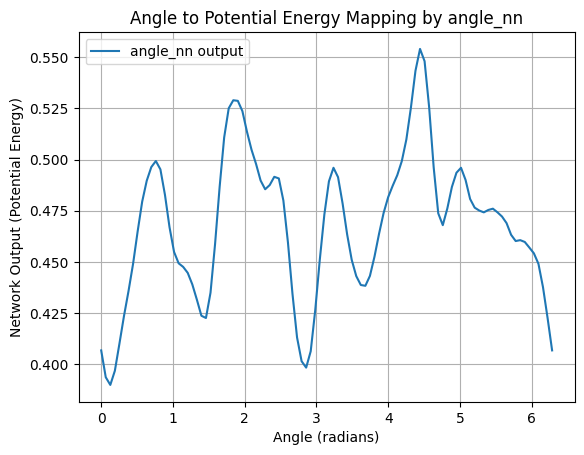

In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 定义角度范围
angles = torch.linspace(0, 2 * np.pi, 100)  # 从0到2π的角度值

# 使用angle_nn计算每个角度对应的能量
with torch.no_grad():  # 关闭梯度追踪
    outputs = system.angle_nn(angles)

# 将结果转换为numpy数组，便于绘图
angles_np = angles.numpy()
outputs_np = outputs.numpy()

# 绘制角度和神经网络输出的曲线
plt.plot(angles_np, outputs_np, label='angle_nn output')
plt.xlabel('Angle (radians)')
plt.ylabel('Network Output (Potential Energy)')
plt.title('Angle to Potential Energy Mapping by angle_nn')
plt.legend()
plt.grid(True)
plt.show()

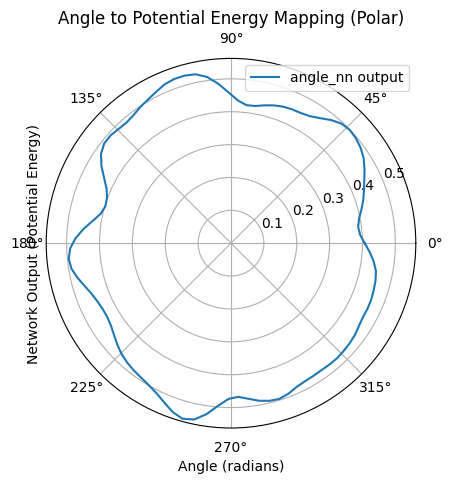

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 定义角度范围
angles = torch.linspace(0, 2 * np.pi, 100)  # 从0到2π的角度值

# 使用angle_nn计算每个角度对应的能量
with torch.no_grad():  # 关闭梯度追踪
    outputs = system.angle_nn(angles)

# 将结果转换为numpy数组，便于绘图
angles_np = angles.numpy()
outputs_np = outputs.numpy()

# 创建极坐标图
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')  # 使用极坐标
ax.plot(angles_np, outputs_np, label='angle_nn output')  # 角度与能量

# 设置极坐标图的标签和标题
ax.set_xlabel('Angle (radians)')
ax.set_ylabel('Network Output (Potential Energy)')
ax.set_title('Angle to Potential Energy Mapping (Polar)')

# 添加网格和图例
ax.legend()
ax.grid(True)

# 显示图像
plt.show()


In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 定义最大时间和采样时间步
T_max = 15
num_samples = 16
t_values = torch.linspace(0, T_max, num_samples)  # 生成从0到T_max的时间步


In [80]:
epsilon_values = []
for t in t_values:
    t_emb = get_timestep_embedding(t.unsqueeze(0), 128)  # 时间嵌入
    epsilon_output = system.epsilon_mlp(t_emb)  # 获取 epsilon_mlp 的输出
    epsilon_values.append(epsilon_output.item())

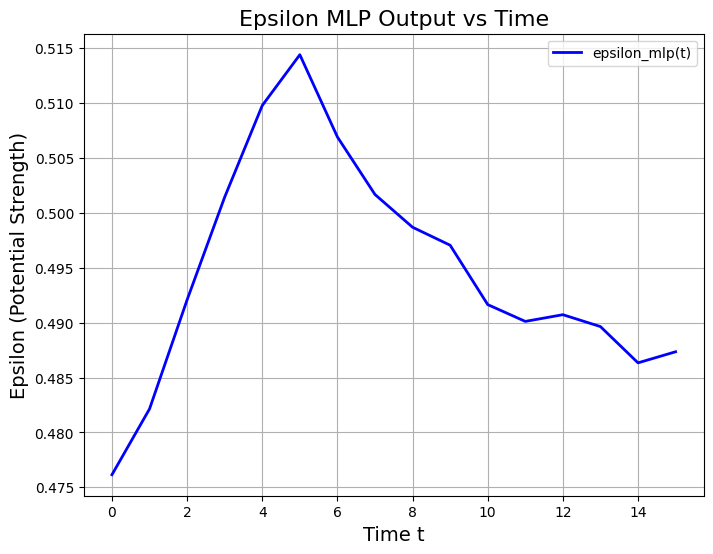

In [81]:
# 转换为 NumPy 数组便于绘图
epsilon_values = np.array(epsilon_values)
t_values_np = t_values.numpy()

# 绘制 epsilon_mlp 随时间 t 的变化曲线
plt.figure(figsize=(8, 6))
plt.plot(t_values_np, epsilon_values, label='epsilon_mlp(t)', color='b', linewidth=2)
plt.title('Epsilon MLP Output vs Time', fontsize=16)
plt.xlabel('Time t', fontsize=14)
plt.ylabel('Epsilon (Potential Strength)', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# p1 能量太大 p2 换傅里叶 p3 反向传播更新力场 p4 能量含时神经网络

In [339]:
!pip install celluloid

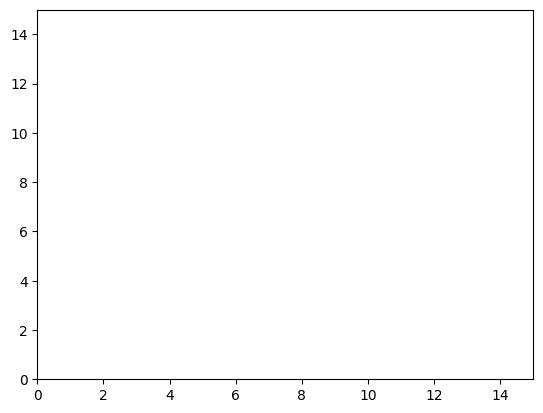

In [419]:
from celluloid import Camera
from matplotlib import pyplot as plt
import random


fig = plt.figure()
plt.xlim([0, 15])
plt.ylim([0, 15])
camera = Camera(fig)

colorsList = random.sample(range(1, 100+1), k = len(system.particles) )
colors = colorsList

plt.scatter(system.particles_warm[:, 0], system.particles_warm[:, 1], s=256, c=colors, cmap='plasma')
camera.snap()

animation = camera.animate()
animation.save('simu_system5.gif', writer = 'pillow', fps=64)

In [390]:
aaa

array([[ 1.3039637 ,  0.9575577 ,  1.8027056 ],
       [ 2.497222  ,  0.85804653,  5.3736806 ],
       [ 3.3189402 ,  1.0392075 ,  3.9647253 ],
       [ 6.294753  ,  1.4707203 ,  2.6748178 ],
       [ 7.56283   , 14.774891  ,  1.0012585 ],
       [ 9.3118925 , 14.881685  ,  5.4057913 ],
       [ 9.6574745 ,  1.0371876 ,  1.6010071 ],
       [11.5409    ,  0.72397614,  3.8969386 ],
       [12.706785  ,  1.37255   ,  5.369646  ],
       [14.200893  ,  0.31130314,  4.8510923 ],
       [ 0.7260046 ,  3.3876753 ,  4.866691  ],
       [ 3.0523405 ,  3.1037874 ,  3.1317418 ],
       [ 3.9321795 ,  2.804037  ,  0.6392534 ],
       [ 5.7963905 ,  0.6280241 ,  0.9751828 ],
       [ 4.9426546 ,  1.7309656 ,  3.137917  ],
       [ 8.575138  ,  0.9269867 ,  2.4054263 ],
       [11.400642  ,  2.1608725 ,  1.2329332 ],
       [10.864663  ,  3.077281  ,  4.682913  ],
       [13.031668  ,  2.7334776 ,  6.1262016 ],
       [14.853867  ,  3.3767138 ,  2.4553888 ],
       [ 1.9576759 ,  3.4883976 ,  5.628

In [342]:
system.particles[:, 0]

tensor([ 0.9833,  2.7230,  4.2336,  5.3702,  7.0448,  8.4895,  9.8338, 11.2976,
        13.0918, 14.7069,  0.8672,  2.6061,  3.9107,  5.5742,  6.8942,  8.4618,
        10.2489, 11.5041, 12.7549, 14.2584,  0.8255,  2.4806,  4.0895,  5.3036,
         7.1806,  8.6890,  9.9015, 11.6553, 13.2007, 14.2676,  1.1860,  2.6972,
         3.8999,  5.3722,  6.9294,  8.4377,  9.8201, 11.3535, 13.0122, 14.3427,
         1.1138,  2.3019,  3.8387,  5.6827,  7.0617,  8.5356, 10.1647, 11.5237,
        12.8834, 14.7303,  0.9316,  2.3724,  3.7624,  5.7291,  7.1131,  8.5533,
         9.8405, 11.3911, 12.8295, 14.5196,  1.1159,  2.4105,  3.8098,  5.6402,
         6.9954,  8.7383,  9.9287, 11.4455, 12.9306, 14.4785,  0.8159,  2.4726,
         4.2205,  5.5705,  7.0270,  8.3165,  9.9714, 11.6704, 13.1879, 14.5825,
         0.9868,  2.6005,  4.0258,  5.3587,  7.0143,  8.4785, 10.1278, 11.4925,
        12.9605, 14.5625,  0.9138,  2.4798,  3.7554,  5.4611,  6.9287,  8.5624,
        10.0704, 11.5614, 12.9797, 14.53